In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt

In [2]:
# Load datasets
train_path = "/Users/ribhavbhatt/Downloads/archive/training.csv"  # Replace with your training dataset path
test_path = "/Users/ribhavbhatt/Downloads/archive/test.csv"    # Replace with your test dataset path

training_data = pd.read_csv(train_path)
testing_data = pd.read_csv(test_path)

In [3]:
# Replace missing values (-999.0) with NaN
training_data.replace(-999.0, np.nan, inplace=True)
testing_data.replace(-999.0, np.nan, inplace=True)

In [4]:
# Separate features and target in training data
X = training_data.drop(columns=["EventId", "Weight", "Label"])
y = training_data["Label"].map({"s": 1, "b": 0})  # Encode target as 1 (signal) and 0 (background)

In [5]:
# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)
testing_data_imputed = imputer.transform(testing_data.drop(columns=["EventId"]))

In [6]:
# Scale features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
testing_data_scaled = scaler.transform(testing_data_imputed)

In [7]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [8]:
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

In [9]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
# Validate the model
y_pred = rf_model.predict(X_val)
y_pred_prob = rf_model.predict_proba(X_val)[:, 1]

In [11]:
# Evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)
classification_rep = classification_report(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.8385
ROC AUC Score: 0.9053
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88     33065
           1       0.79      0.71      0.75     16935

    accuracy                           0.84     50000
   macro avg       0.83      0.81      0.81     50000
weighted avg       0.84      0.84      0.84     50000



In [12]:
# Feature Importance
feature_importances = rf_model.feature_importances_
feature_names = X.columns

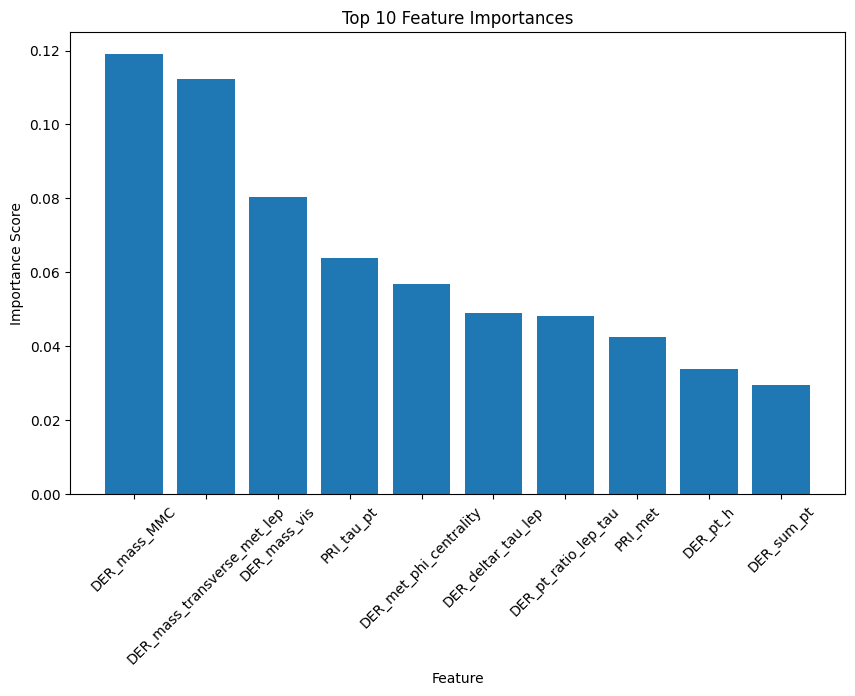

In [13]:
# Plot the top 10 features
sorted_idx = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(10), feature_importances[sorted_idx][:10], align="center")
plt.xticks(range(10), feature_names[sorted_idx][:10], rotation=45)
plt.title("Top 10 Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [14]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [15]:
# Perform RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

In [16]:
# Best parameters and evaluation
best_params = rf_random.best_params_
print(f"Best Hyperparameters: {best_params}")
best_rf_model = rf_random.best_estimator_

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None}
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 1.8min
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  56.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 2.0min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 2.0min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  53.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 2.9min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 2.0min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.0min
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200;

In [17]:
# Test set predictions
test_predictions = best_rf_model.predict_proba(testing_data_scaled)[:, 1]

In [18]:
# Prepare submission file
submission = pd.DataFrame({
    "EventId": testing_data["EventId"],
    "RankOrder": test_predictions.argsort().argsort() + 1,
    "Class": np.where(test_predictions > 0.5, "s", "b")
})

submission.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.


In [19]:
# Prepare submission file
submission1 = pd.DataFrame({
    "EventId": testing_data["EventId"],
    "RankOrder": test_predictions.argsort().argsort() + 1,
    "Class": np.where(test_predictions > 0.5, "s", "b")
})

submission1.to_csv("submission1.csv", index=False)
print("Submission file 'submission1.csv' created successfully.")

Submission file 'submission1.csv' created successfully.


In [20]:
# Import necessary libraries for handling imbalance
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

ModuleNotFoundError: No module named 'imblearn'

In [21]:
# Import necessary libraries for handling imbalance
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

ModuleNotFoundError: No module named 'imblearn'

In [22]:
from imblearn.over_sampling import SMOTE
print("SMOTE is successfully imported!")

ModuleNotFoundError: No module named 'imblearn'

In [23]:
# Import necessary libraries for handling imbalance
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

ModuleNotFoundError: No module named 'imblearn'